In [1]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [19]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML
import pickle

SEED = 42

def guardar_agente(agente, ruta_archivo="agente_sarsa_rbf.pkl"):
    """Guarda el agente AgenteSARSARBF en un archivo pickle."""
    datos = {
        "alpha": agente.alpha,
        "gamma": agente.gamma,
        "epsilon": agente.epsilon,
        "decay": agente.decay,
        "num_centers": agente.rbf.num_centers,
        "sigma": agente.rbf.sigma,
        "theta": agente.theta,
        "stats": agente.stats,
        "episode_lengths": agente.episode_lengths,
        "low": agente.low,
        "high": agente.high
    }
    with open(ruta_archivo, "wb") as f:
        pickle.dump(datos, f)

def cargar_agente(ruta_archivo="agente_sarsa_rbf.pkl"):
    """Carga un agente AgenteSARSARBF desde un archivo pickle."""
    with open(ruta_archivo, "rb") as f:
        datos = pickle.load(f)

    env = gym.make("MountainCar-v0")
    env.reset(seed=SEED)

    agente = AgenteSARSARBF(
        env,
        alpha=datos["alpha"],
        gamma=datos["gamma"],
        epsilon=datos["epsilon"],
        decay=datos["decay"],
        num_centers=tuple(datos["num_centers"]),
        sigma=datos["sigma"]
    )

    # Restaurar parámetros
    agente.theta = datos["theta"]
    agente.stats = datos["stats"]
    agente.episode_lengths = datos["episode_lengths"]
    agente.low = datos["low"]
    agente.high = datos["high"]

    return agente

# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)

# -------------------- EJECUCIÓN DE UN EPISODIO --------------------

def ejecutar_episodio_y_mostrar(agente, render=False):
    """Ejecuta un episodio con la política aprendida y muestra la evolución de la posición."""
    env = agente.env
    state, _ = env.reset()

    random.seed(SEED)
    np.random.seed(SEED)
    
    done = False
    total_reward = 0
    posiciones = []

    while not done:
        if render:
            env.render()
        posiciones.append(state[0])  # Guardamos la posición del coche
        action = agente.seleccionar_accion(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    
    # Mostrar gráfico de posiciones
    plt.figure(figsize=(6, 3))
    plt.plot(posiciones)
    plt.title("Evolución de la posición del coche")
    plt.xlabel("Paso del episodio")
    plt.ylabel("Posición")
    plt.grid(True)
    plt.show()
    
    print(f"Recompensa total obtenida: {total_reward:.2f}")

# -------------------- EVALUACIÓN DE LA POLÍTICA --------------------

def evaluar_politica(agente, num_episodios=100):
    """Evalúa la política del agente ejecutando múltiples episodios y muestra estadísticas."""

    env = agente.env
    recompensas = []
    longitudes = []
    semillas_fallidas = []

    for i in range(num_episodios):
        random.seed(i)
        np.random.seed(i)
        env.action_space.seed(i)
        state, _ = env.reset(seed=i)
        done = False
        total_reward = 0
        posiciones = []
        pasos = 0

        terminated = False
        truncated = False
        
        while not done:
            posiciones.append(state[0])
            action = agente.seleccionar_accion_greedy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            pasos += 1

            if truncated:
                semillas_fallidas.append(i)

        recompensas.append(total_reward)
        longitudes.append(pasos)
        
        env.close()

    # Resumen estadístico
    print("📊 Resultados de evaluación:")
    print(f"  Episodios evaluados: {num_episodios}")
    print(f"  Recompensa media:    {np.mean(recompensas):.2f} ± {np.std(recompensas):.2f}")
    print(f"  Recompensa min/max:  {np.max(recompensas):.2f} / {np.min(recompensas):.2f}")

    print(f"  Episodios exitosos:  {num_episodios - len(semillas_fallidas)}")
    print(f"  Episodios fallidos:  {len(semillas_fallidas)}")
    print(f"  Semillas fallidas: {semillas_fallidas}")



# Objeto AgenteSARSA-SemiGradiente con RBF

In [7]:
import numpy as np
import random
from tqdm import tqdm

class RBFBasisFunctions:
    def __init__(self, low, high, num_centers=(5, 5), sigma=0.5):
        self.low = np.array(low)
        self.high = np.array(high)
        self.num_centers = np.array(num_centers)
        self.sigma = sigma

        # Normalizar límites para trabajar en [0, 1]
        self.range = self.high - self.low

        # Crear centros normalizados en grilla regular
        pos_centers = np.linspace(0, 1, num_centers[0])
        vel_centers = np.linspace(0, 1, num_centers[1])
        self.centers = np.array([[p, v] for p in pos_centers for v in vel_centers])

        self.num_features = len(self.centers)

    def normalize_state(self, state):
        return (np.array(state) - self.low) / self.range

    def get_features(self, state):
        state = self.normalize_state(state)
        features = np.exp(-np.sum((state - self.centers) ** 2, axis=1) / (2 * self.sigma ** 2))
        return features


class AgenteSARSARBF:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, num_centers=(5, 5), sigma=0.5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high

        self.rbf = RBFBasisFunctions(self.low, self.high, num_centers, sigma)
        self.d = self.rbf.num_features
        self.theta = np.zeros((self.nA, self.d))

        self.stats = []
        self.episode_lengths = []

    def _phi(self, state):
        return self.rbf.get_features(state)

    def _Q(self, state, action):
        return np.dot(self.theta[action], self._phi(state))

    def _epsilon_soft_policy_rbf(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        q_values = np.nan_to_num(q_values)

        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        policy = np.clip(policy, 0, 1)
        return policy / policy.sum() if policy.sum() > 0 else np.ones(self.nA) / self.nA

    def seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy_rbf(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        """Selecciona una acción usando la política greedy."""
        q_values = [self._Q(state, a) for a in range(self.nA)]
        action = np.argmax(q_values)
        return action


    def entrenar(self, num_episodes=5000, mostrar_barra=True, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset()
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)

                phi = self._phi(state)
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not np.isnan(delta) and not np.isinf(delta):
                    self.theta[action] += self.alpha * delta * phi
                    self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

In [8]:
def evaluar_configuracion(params, env_name="MountainCar-v0"):
    alpha, gamma, epsilon, decay, num_centers, sigma = params
    env = gym.make(env_name)
    agente = AgenteSARSARBF(
        env,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        decay=decay,
        num_centers=num_centers,
        sigma=sigma
    )
    agente.entrenar(num_episodes=5000, mostrar_barra=False)
    recompensa_final = np.mean(agente.stats[-100:])  # Media últimos 100 episodios
    return (alpha, gamma, epsilon, decay, num_centers, sigma, recompensa_final)

def random_search_rbf(env_name="MountainCar-v0", n_configs=100, seed=42):
    # Espacios de búsqueda
    alphas = [0.01, 0.05, 0.1]
    gammas = np.linspace(0.8, 1.0, 5)
    epsilons = np.linspace(0.1, 1.0, 5)
    num_centers_list = [(5, 5), (7, 7), (9, 9)]
    sigmas = [0.2, 0.5, 0.7]
    decays = [True, False]

    # Combinaciones posibles y aleatorias
    combinaciones = list(product(alphas, gammas, epsilons, decays, num_centers_list, sigmas))
    np.random.seed(seed)
    seleccionadas = np.random.choice(len(combinaciones), size=min(n_configs, len(combinaciones)), replace=False)
    combinaciones_random = [combinaciones[i] for i in seleccionadas]

    mejor_config = None
    mejor_recompensa = -float("inf")
    resultados = []

    print("🔍 Ejecutando búsqueda paralela de hiperparámetros (SARSA-RBF)...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, env_name) for combo in combinaciones_random]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay, num_centers, sigma, recompensa = future.result()
            resultados.append((alpha, gamma, epsilon, decay, num_centers, sigma, recompensa))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, decay, num_centers, sigma)

    print("\n✅ Mejor configuración encontrada:")
    print(f" α = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f" num_centers = {mejor_config[4]}, sigma = {mejor_config[5]}")
    print(f" → Recompensa media final: {mejor_recompensa:.4f}")

In [ ]:
random_search_rbf()

In [10]:
# Ejecución de ejemplo
env = gym.make("MountainCar-v0")
env.reset(seed=SEED)
agente = AgenteSARSARBF(env, alpha=0.01, gamma=1.0, epsilon=1.0, num_centers=(9, 9), sigma=0.2, decay=True)
agente.entrenar(num_episodes=10000)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [24:11<00:00,  6.89it/s]


In [20]:
guardar_agente(agente)

In [27]:
agent = cargar_agente("agente_sarsa_rbf.pkl")

# Resultados de agente SARSA SemiGradiente con RBF

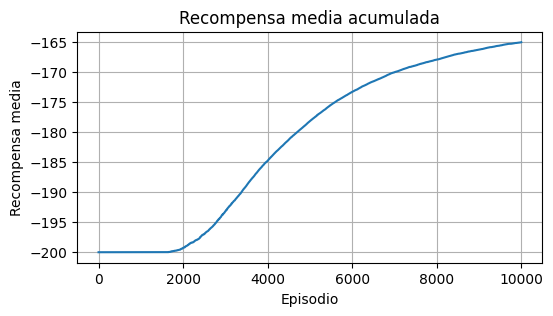

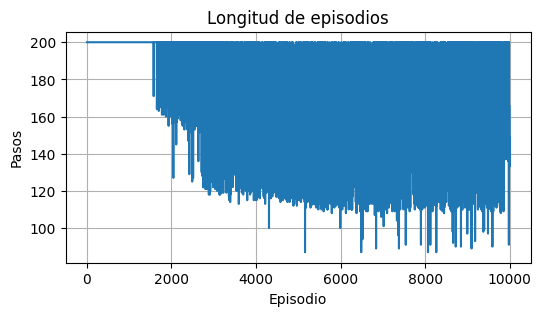

In [28]:
mostrar_resultados_agente_continuo(agent)

In [29]:
evaluar_politica(agent, num_episodios=10000)

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -150.10 ± 16.42
  Recompensa min/max:  -108.00 / -191.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [24]:
def grabar_video_agente(agente, seed, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """

    random.seed(seed)
    np.random.seed(seed)

    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agente.seleccionar_accion_greedy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

In [26]:
nombre_archivo = "video_mountaincar_rbf.gif"

grabar_video_agente(agent, seed=1, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 141
🎥 Vídeo guardado en: video_mountaincar_rbf.gif
🏁 Recompensa total obtenida: -141.00
